In [219]:
import os
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
import datetime as dt

In [2]:
DATA_PATH ='C:\\Boot Camp\Homework\\final-project\\data\\Loan_status_2007-2020Q3.gzip'

In [3]:
loans = pd.read_csv(DATA_PATH)
loans.head()

C:\Users\narje\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Unnamed: 0       id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0           0  1077501     5000.0       5000.0           4975.0   36 months   
1           1  1077430     2500.0       2500.0           2500.0   60 months   
2           2  1077175     2400.0       2400.0           2400.0   36 months   
3           3  1076863    10000.0      10000.0          10000.0   36 months   
4           4  1075358     3000.0       3000.0           3000.0   60 months   

  int_rate  installment grade sub_grade  ... hardship_start_date  \
0   10.65%       162.87     B        B2  ...                 NaN   
1   15.27%        59.83     C        C4  ...                 NaN   
2   15.96%        84.33     C        C5  ...                 NaN   
3   13.49%       339.31     C        C1  ...                 NaN   
4   12.69%        67.79     B        B5  ...                 NaN   

  hardship_end_date payment_plan_start_date  hardship_length hardship_dpd  \
0               NaN                     NaN              NaN          NaN   
1               NaN                     NaN              NaN          NaN   
2               NaN                     NaN              NaN          NaN   
3               NaN                     NaN              NaN          NaN   
4               NaN                     NaN              NaN          NaN   

  hardship_loan_status orig_projected_additional_accrued_interest  \
0                  NaN                                        NaN   
1                  NaN                                        NaN   
2                  NaN                                        NaN   
3                  NaN                                        NaN   
4                  NaN                                        NaN   

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   

  debt_settlement_flag  
0                    N  
1                    N  
2                    N  
3                    N  
4                    N  

[5 rows x 142 columns]

In [4]:
loans.count()

Unnamed: 0                                    2925493
id                                            2925493
loan_amnt                                     2925492
funded_amnt                                   2925492
funded_amnt_inv                               2925492
                                               ...   
hardship_loan_status                           143411
orig_projected_additional_accrued_interest     179240
hardship_payoff_balance_amount                 182076
hardship_last_payment_amount                   182076
debt_settlement_flag                          2925492
Length: 142, dtype: int64

In [5]:
#create sample data for first 500 rows just to check it
sample=loans.head(500)

In [6]:
sample.to_csv('C:\\Boot Camp\Homework\\final-project\\data\\sample_main_data.csv', index=False)

In [7]:
loans.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [8]:
#predict the loan_status variable. What are the value counts for this variable
loans["loan_status"].value_counts(dropna=False)

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
NaN                                                          1
Name: loan_status, dtype: int64

In [9]:
#keep the loans with status "Fully Paid" or "Charged Off"
ploans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]


In [11]:
ploans.count()

Unnamed: 0                                    1860331
id                                            1860331
loan_amnt                                     1860331
funded_amnt                                   1860331
funded_amnt_inv                               1860331
                                               ...   
hardship_loan_status                            12684
orig_projected_additional_accrued_interest      19213
hardship_payoff_balance_amount                  22049
hardship_last_payment_amount                    22049
debt_settlement_flag                          1860331
Length: 142, dtype: int64

In [12]:
#Number of loan statuses with Fully paid or Charged off (we want to keep it as label of data for ML section)
ploans["loan_status"].value_counts(dropna=False)

Fully Paid     1497783
Charged Off     362548
Name: loan_status, dtype: int64

In [13]:
#percentage of each value
ploans["loan_status"].value_counts(normalize=True)

Fully Paid     0.805116
Charged Off    0.194884
Name: loan_status, dtype: float64

In [14]:
#calculate the percentage of missing data for each feature
missing_values_mean = ploans.isnull().mean().sort_values(ascending=False)

In [15]:
missing_values_mean.head(10)

next_pymnt_d               1.000000
hardship_loan_status       0.993182
deferral_term              0.993176
hardship_status            0.993176
hardship_dpd               0.993176
hardship_length            0.993176
payment_plan_start_date    0.993176
hardship_end_date          0.993176
hardship_start_date        0.993176
hardship_type              0.993176
dtype: float64

Text(0, 0.5, 'Feature count')

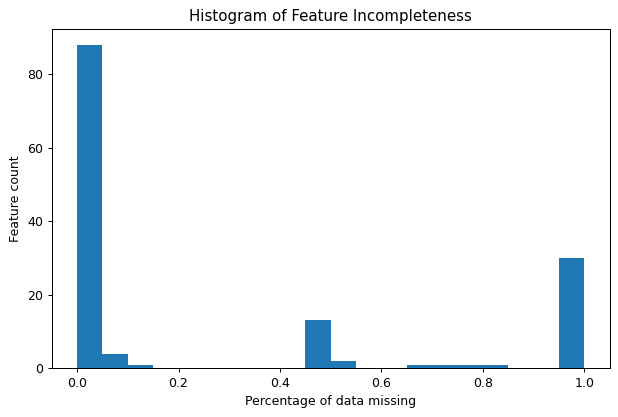

In [16]:
#visualize the distribution of missing data percentages
plt.figure(figsize=(8,5), dpi=90)
missing_values_mean.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Percentage of data missing')
plt.ylabel('Feature count')

In [17]:
# store all variables missing more than 30% data
drop_values_mean=sorted(list(missing_values_mean[missing_values_mean>0.3].index))
len(drop_values_mean)

49

In [18]:
drop_values_mean

['all_util',
 'annual_inc_joint',
 'deferral_term',
 'dti_joint',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'max_bal_bc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'next_pymnt_d',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'orig_projected_additional_accrued_interest',
 'payment_plan_start_date',
 'revol_bal_joint',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_num_rev_accts',
 'sec_app_

In [19]:
# Drop features
ploans.drop(columns=drop_values_mean, inplace=True, axis=1)

C:\Users\narje\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
ploans.shape

(1860331, 93)

In [21]:
ploans.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_pa

In [22]:
#keep needed features after checking Data Dictionary
keep_list=['loan_amnt','term','int_rate', 'installment', 'grade', 'sub_grade','emp_length', 'home_ownership', 'annual_inc','issue_d', 'loan_status','pymnt_plan','addr_state', 'dti', 'earliest_cr_line','fico_range_low', 'fico_range_high', 'open_acc', 'revol_bal', 'revol_util','total_acc','total_pymnt','total_rec_late_fee','last_pymnt_d','application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal','chargeoff_within_12_mths','mort_acc','num_il_tl','pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag','pub_rec']

print("Keep features: ", len(keep_list))

Keep features:  39


In [23]:
ml_loans=ploans

In [24]:
drop_list = [col for col in ml_loans.columns if col not in keep_list]
drop_list

['Unnamed: 0',
 'id',
 'funded_amnt',
 'funded_amnt_inv',
 'emp_title',
 'verification_status',
 'url',
 'purpose',
 'title',
 'zip_code',
 'delinq_2yrs',
 'inq_last_6mths',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'perc

In [25]:
ml_loans.drop(labels=drop_list, axis=1, inplace=True)
ml_loans.shape

(1860331, 39)

In [26]:
#show float type with 2digits after point
pd.options.display.float_format = "{:.2f}".format

In [27]:
ml_loans['loan_amnt'].describe()
#Loan amounts range from $500 to $40000 and median of $12,000

count   1860331.00
mean      14588.27
std        8970.47
min         500.00
25%        7950.00
50%       12000.00
75%       20000.00
max       40000.00
Name: loan_amnt, dtype: float64

In [28]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

C:\Users\narje\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


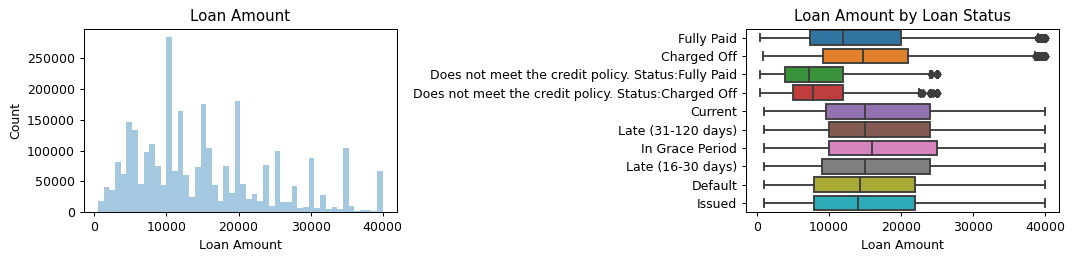

In [29]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

In [30]:
ml_loans.groupby('loan_status')['loan_amnt'].describe()

count     mean     std    min     25%      50%      75%  \
loan_status                                                                
Charged Off  362548.00 15899.50 9083.26 900.00 9250.00 14700.00 21000.00   
Fully Paid  1497783.00 14270.88 8914.01 500.00 7350.00 12000.00 20000.00   

                 max  
loan_status           
Charged Off 40000.00  
Fully Paid  40000.00

In [31]:
ml_loans.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status',
       'pymnt_plan', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_rec_late_fee', 'last_pymnt_d',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'mort_acc', 'num_il_tl',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_il_high_credit_limit', 'hardship_flag',
       'debt_settlement_flag'],
      dtype='object')

In [32]:
ml_loans["loan_status"].head(10)

0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
4     Fully Paid
5     Fully Paid
6     Fully Paid
7     Fully Paid
8    Charged Off
9    Charged Off
Name: loan_status, dtype: object

In [33]:
#Finding the count and percentage of values that are missing in cleaned data frame
df_null = pd.DataFrame({'Count': ml_loans.isnull().sum(), 'Percent': 100*loans.isnull().sum()/len(ml_loans)})

In [34]:
#printing columns with null count more than 0
df_null[df_null['Count'] > 0] 

Count  Percent
chargeoff_within_12_mths       56.00     0.01
dti                          1108.00     0.17
emp_length                 117196.00    11.03
hardship_flag                9354.00     2.07
last_pymnt_d                 3289.00     0.26
mort_acc                    47281.00     2.69
num_il_tl                   67527.00     3.78
pub_rec_bankruptcies          697.00     0.07
revol_util                   1398.00     0.14
tax_liens                      39.00     0.01
tot_coll_amt                67527.00     3.78
tot_cur_bal                 67527.00     3.78
tot_hi_cred_lim             67527.00     3.78
total_bal_ex_mort           47281.00     2.69
total_il_high_credit_limit  67527.00     3.78

In [35]:
#drop any columns where 80% or more data is missing
df1 = ml_loans.dropna(axis=1, thresh=int(0.80*len(ml_loans)))

In [37]:
#choose only data which is necessary for Machine learning process
df_LC=df1

<AxesSubplot:>

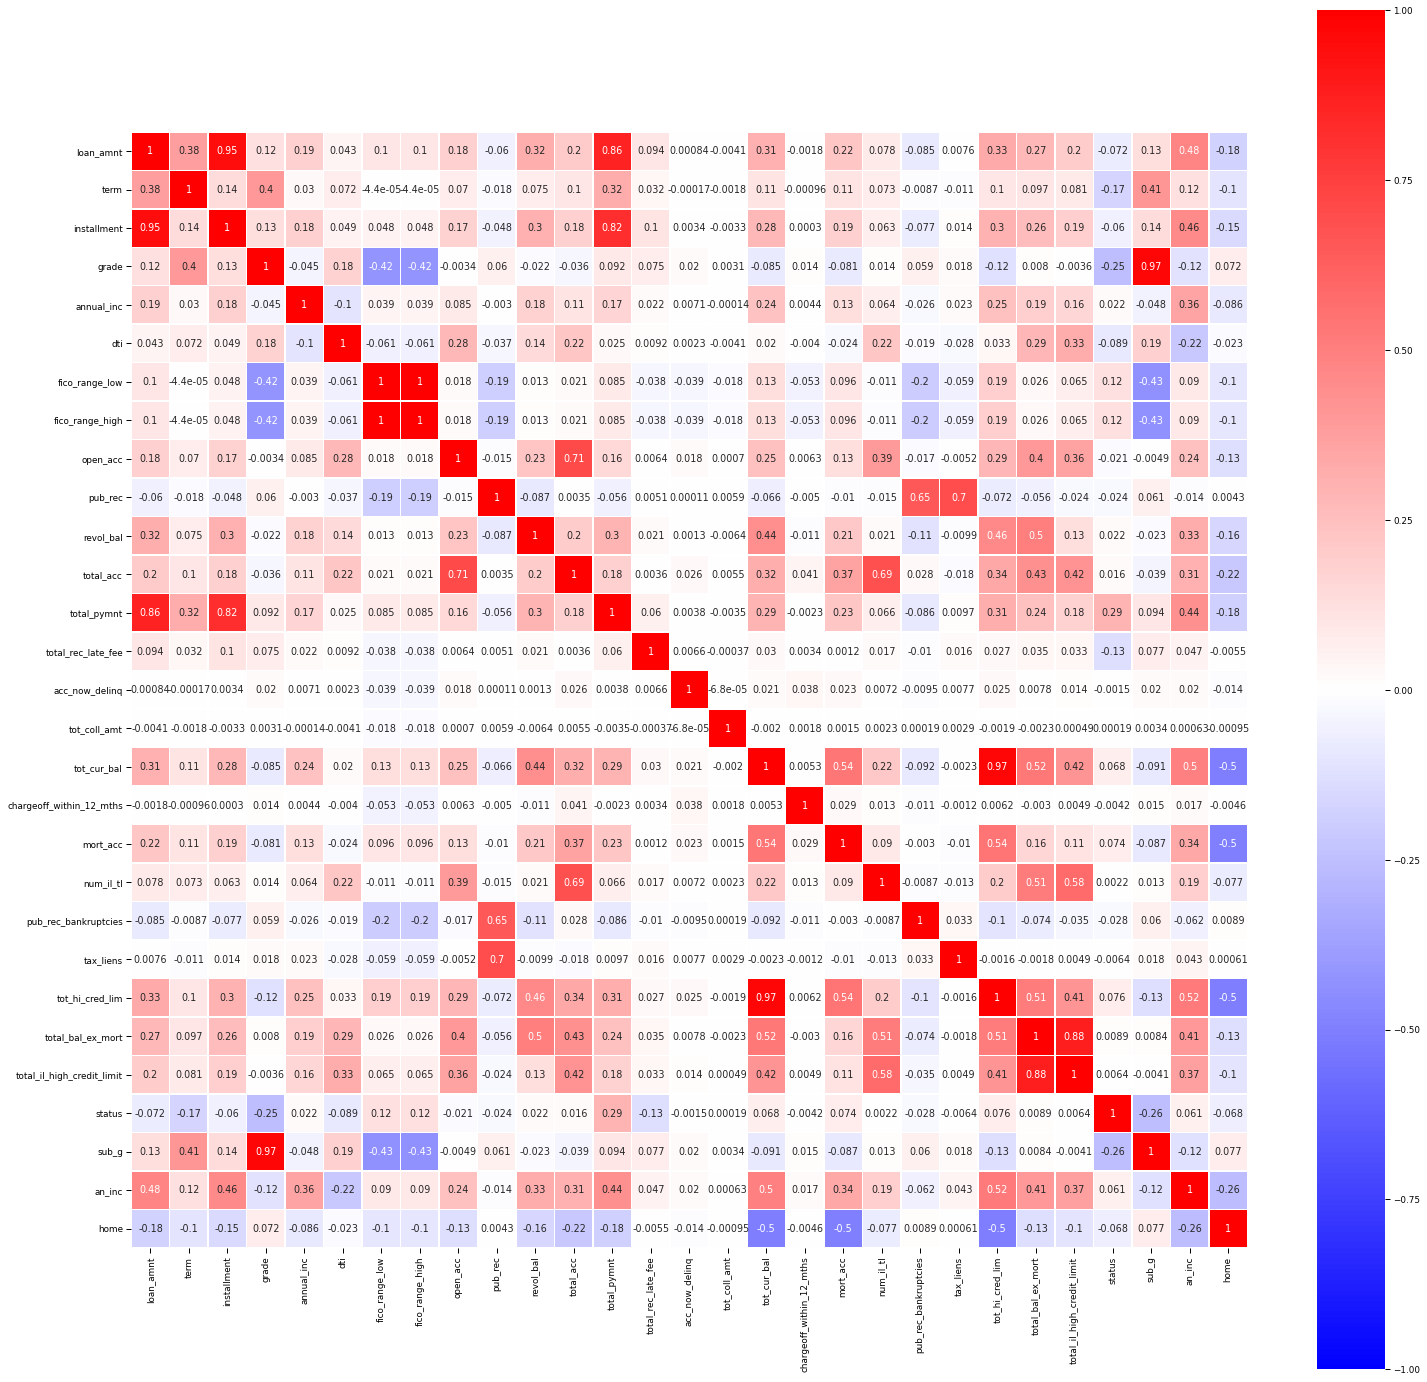

In [38]:
plt.figure(figsize=(25,25))
sns.set_context("paper", font_scale=1)
#finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df_LC.assign(status=df_LC.loan_status.astype('category').cat.codes,
                         grade=df_LC.grade.astype('category').cat.codes,
                         sub_g=df_LC.sub_grade.astype('category').cat.codes,
                         term=df_LC.term.astype('category').cat.codes,
                        #emp_l=df_LC.emp_length.astype('category').cat.codes,
                         an_inc =df_LC.annual_inc.astype('category').cat.codes,
                        home=df_LC.home_ownership.astype('category').cat.codes,
                        dti=df_LC.dti.astype('category').cat.codes).corr(), 
                         annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

In [239]:
#drop categories they don't provide any valuable info
df_LC = df1.filter(['loan_amnt','int_rate','emp_length','home_ownership','annual_inc','dti','loan_status','total_pymnt','fico_range_high'])

In [240]:
#printing the count and null values in the dataframe
dflc_null = pd.DataFrame({'Count': df_LC.isnull().sum(), 'Percent': 100*df_LC.isnull().sum()/len(df_LC)})
dflc_null[dflc_null['Count'] > 0]

Count  Percent
emp_length  117196     6.30
dti           1108     0.06

In [241]:
# dropping the null rows since we have sufficient amount of data and there is no need to fill the null values.
df_LC.dropna()

loan_amnt int_rate emp_length home_ownership  annual_inc   dti  \
0          5000.00   10.65%  10+ years           RENT    24000.00 27.65   
1          2500.00   15.27%   < 1 year           RENT    30000.00  1.00   
2          2400.00   15.96%  10+ years           RENT    12252.00  8.72   
3         10000.00   13.49%  10+ years           RENT    49200.00 20.00   
4          3000.00   12.69%     1 year           RENT    80000.00 17.94   
...            ...      ...        ...            ...         ...   ...   
2925488   24000.00   23.99%   < 1 year           RENT   107000.00 11.65   
2925489   10000.00    7.99%  10+ years       MORTGAGE    65000.00 19.55   
2925490   10050.00   16.99%    8 years           RENT    37000.00 20.56   
2925491    6000.00   11.44%    5 years           RENT    41000.00 19.99   
2925492   30000.00   25.49%    4 years       MORTGAGE   105700.00 27.26   

         loan_status  total_pymnt  fico_range_high  
0         Fully Paid      5863.16           739.00  
1        Charged Off      1014.53           744.00  
2         Fully Paid      3005.67           739.00  
3         Fully Paid     12231.89           694.00  
4         Fully Paid      4066.91           699.00  
...              ...          ...              ...  
2925488  Charged Off      7749.83           674.00  
2925489   Fully Paid     11233.83           729.00  
2925490  Charged Off      9484.88           709.00  
2925491   Fully Paid      6917.54           674.00  
2925492  Charged Off      5490.06           699.00  

[1743060 rows x 9 columns]

In [242]:
#encode loan staus to 0 and 1
df_LC.loan_status=df_LC.loan_status.astype('category').cat.codes
df_LC.head()

loan_amnt int_rate emp_length home_ownership  annual_inc   dti  \
0    5000.00   10.65%  10+ years           RENT    24000.00 27.65   
1    2500.00   15.27%   < 1 year           RENT    30000.00  1.00   
2    2400.00   15.96%  10+ years           RENT    12252.00  8.72   
3   10000.00   13.49%  10+ years           RENT    49200.00 20.00   
4    3000.00   12.69%     1 year           RENT    80000.00 17.94   

   loan_status  total_pymnt  fico_range_high  
0            1      5863.16           739.00  
1            0      1014.53           744.00  
2            1      3005.67           739.00  
3            1     12231.89           694.00  
4            1      4066.91           699.00

In [243]:
df_LC.dtypes

loan_amnt          float64
int_rate            object
emp_length          object
home_ownership      object
annual_inc         float64
dti                float64
loan_status           int8
total_pymnt        float64
fico_range_high    float64
dtype: object

In [244]:
#transform the data to account for any skewness in the variable distribution, using Box-cox transformation
numerical = df_LC.columns[df_LC.dtypes == 'float64']
for i in numerical:
    if df_LC[i].min() > 0:
        transformed, lamb = boxcox(df_LC.loc[ml_loans[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            df_LC.loc[ml_loans[i].notnull(), i] = transformed

In [245]:
df_LC["home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [246]:
df_LC['int_rate'] = df_LC['int_rate'].str.rstrip('%')
df_LC['int_rate'] = df_LC['int_rate'].astype('float32')
df_LC.head()

loan_amnt  int_rate emp_length home_ownership  annual_inc   dti  \
0      51.08     10.65  10+ years           RENT    24000.00 27.65   
1      39.66     15.27   < 1 year           RENT    30000.00  1.00   
2      39.07     15.96  10+ years           RENT    12252.00  8.72   
3      65.55     13.49  10+ years           RENT    49200.00 20.00   
4      42.41     12.69     1 year           RENT    80000.00 17.94   

   loan_status  total_pymnt  fico_range_high  
0            1      5863.16             0.10  
1            0      1014.53             0.10  
2            1      3005.67             0.10  
3            1     12231.89             0.10  
4            1      4066.91             0.10

In [247]:
df_LC['emp_length'] = df_LC['emp_length'].str.rstrip('<+ years')
df_LC['emp_length'] = df_LC['emp_length'].str.replace('< 1', '1')
df_LC['emp_length'] = df_LC['emp_length'].astype('float32')
df_LC.head()

loan_amnt  int_rate  emp_length home_ownership  annual_inc   dti  \
0      51.08     10.65       10.00           RENT    24000.00 27.65   
1      39.66     15.27        1.00           RENT    30000.00  1.00   
2      39.07     15.96       10.00           RENT    12252.00  8.72   
3      65.55     13.49       10.00           RENT    49200.00 20.00   
4      42.41     12.69        1.00           RENT    80000.00 17.94   

   loan_status  total_pymnt  fico_range_high  
0            1      5863.16             0.10  
1            0      1014.53             0.10  
2            1      3005.67             0.10  
3            1     12231.89             0.10  
4            1      4066.91             0.10

In [249]:
df_LC["loan_amnt"]=df_LC["loan_amnt"].astype('float32')
df_LC["annual_inc"]=df_LC["annual_inc"].astype('float32')
df_LC["dti"]=df_LC["dti"].astype('float32')
df_LC["total_pymnt"]=df_LC["total_pymnt"].astype('float32')
df_LC["fico_range_high"]=df_LC["fico_range_high"].astype('float32')

df_LC.head()

loan_amnt  int_rate  emp_length home_ownership  annual_inc   dti  \
0      51.08     10.65       10.00           RENT    24000.00 27.65   
1      39.66     15.27        1.00           RENT    30000.00  1.00   
2      39.07     15.96       10.00           RENT    12252.00  8.72   
3      65.55     13.49       10.00           RENT    49200.00 20.00   
4      42.41     12.69        1.00           RENT    80000.00 17.94   

   loan_status  total_pymnt  fico_range_high  
0            1      5863.16             0.10  
1            0      1014.53             0.10  
2            1      3005.67             0.10  
3            1     12231.89             0.10  
4            1      4066.91             0.10

In [314]:
#categorical variables for the analysis and the machne learning algorithms doesn't take categorical and string variables directly, we have to creat dummy variables for them
# it would be wrong in our analysis since a lot of these variables have multiple categories. Just using weights can cause discrepencies in the algorithm. Instead, we will one hot encode these so that we have a 1 wherever that category turns up and 0 otherwise. This will also create seperate columns for each level of category. Also, we'll be dropping one of the categories so that we have N-1 columns instead of N.
df_ml = pd.get_dummies(df_LC, drop_first=True)
df_ml

loan_amnt  int_rate  emp_length  annual_inc   dti  loan_status  \
0            51.08     10.65       10.00    24000.00 27.65            1   
1            39.66     15.27        1.00    30000.00  1.00            0   
2            39.07     15.96       10.00    12252.00  8.72            1   
3            65.55     13.49       10.00    49200.00 20.00            1   
4            42.41     12.69        1.00    80000.00 17.94            1   
...            ...       ...         ...         ...   ...          ...   
2925488      89.49     23.99        1.00   107000.00 11.65            0   
2925489      65.55      7.99       10.00    65000.00 19.55            1   
2925490      65.66     16.99        8.00    37000.00 20.56            0   
2925491      54.56     11.44        5.00    41000.00 19.99            1   
2925492      96.83     25.49        4.00   105700.00 27.26            0   

         total_pymnt  fico_range_high  home_ownership_MORTGAGE  \
0            5863.16             0.10                        0   
1            1014.53             0.10                        0   
2            3005.67             0.10                        0   
3           12231.89             0.10                        0   
4            4066.91             0.10                        0   
...              ...              ...                      ...   
2925488      7749.83             0.10                        0   
2925489     11233.83             0.10                        1   
2925490      9484.88             0.10                        0   
2925491      6917.54             0.10                        0   
2925492      5490.06             0.10                        1   

         home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  \
0                          0                     0                   0   
1                          0                     0                   0   
2                          0                     0                   0   
3                          0                     0                   0   
4                          0                     0                   0   
...                      ...                   ...                 ...   
2925488                    0                     0                   0   
2925489                    0                     0                   0   
2925490                    0                     0                   0   
2925491                    0                     0                   0   
2925492                    0                     0                   0   

         home_ownership_RENT  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  
...                      ...  
2925488                    1  
2925489                    0  
2925490                    1  
2925491                    1  
2925492                    0  

[1860331 rows x 13 columns]

In [316]:
df_ml.dtypes

loan_amnt                  float32
int_rate                   float32
emp_length                 float32
annual_inc                 float32
dti                        float32
loan_status                   int8
total_pymnt                float32
fico_range_high            float32
home_ownership_MORTGAGE      uint8
home_ownership_NONE          uint8
home_ownership_OTHER         uint8
home_ownership_OWN           uint8
home_ownership_RENT          uint8
dtype: object

In [315]:
df_ml.to_csv('C:\\Boot Camp\Homework\\final-project\\data\\ML_data.csv', index=False)

In [279]:
df_ml.dropna()

loan_amnt  int_rate  emp_length  annual_inc   dti  loan_status  \
0            51.08     10.65       10.00    24000.00 27.65            1   
1            39.66     15.27        1.00    30000.00  1.00            0   
2            39.07     15.96       10.00    12252.00  8.72            1   
3            65.55     13.49       10.00    49200.00 20.00            1   
4            42.41     12.69        1.00    80000.00 17.94            1   
...            ...       ...         ...         ...   ...          ...   
2925488      89.49     23.99        1.00   107000.00 11.65            0   
2925489      65.55      7.99       10.00    65000.00 19.55            1   
2925490      65.66     16.99        8.00    37000.00 20.56            0   
2925491      54.56     11.44        5.00    41000.00 19.99            1   
2925492      96.83     25.49        4.00   105700.00 27.26            0   

         total_pymnt  fico_range_high  home_ownership_MORTGAGE  \
0            5863.16             0.10                        0   
1            1014.53             0.10                        0   
2            3005.67             0.10                        0   
3           12231.89             0.10                        0   
4            4066.91             0.10                        0   
...              ...              ...                      ...   
2925488      7749.83             0.10                        0   
2925489     11233.83             0.10                        1   
2925490      9484.88             0.10                        0   
2925491      6917.54             0.10                        0   
2925492      5490.06             0.10                        1   

         home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  \
0                          0                     0                   0   
1                          0                     0                   0   
2                          0                     0                   0   
3                          0                     0                   0   
4                          0                     0                   0   
...                      ...                   ...                 ...   
2925488                    0                     0                   0   
2925489                    0                     0                   0   
2925490                    0                     0                   0   
2925491                    0                     0                   0   
2925492                    0                     0                   0   

         home_ownership_RENT  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  
...                      ...  
2925488                    1  
2925489                    0  
2925490                    1  
2925491                    1  
2925492                    0  

[1743060 rows x 13 columns]

In [304]:
pd.DataFrame(df_ml).fillna(0)

loan_amnt  int_rate  emp_length  annual_inc   dti  loan_status  \
0            51.08     10.65       10.00    24000.00 27.65            1   
1            39.66     15.27        1.00    30000.00  1.00            0   
2            39.07     15.96       10.00    12252.00  8.72            1   
3            65.55     13.49       10.00    49200.00 20.00            1   
4            42.41     12.69        1.00    80000.00 17.94            1   
...            ...       ...         ...         ...   ...          ...   
2925488      89.49     23.99        1.00   107000.00 11.65            0   
2925489      65.55      7.99       10.00    65000.00 19.55            1   
2925490      65.66     16.99        8.00    37000.00 20.56            0   
2925491      54.56     11.44        5.00    41000.00 19.99            1   
2925492      96.83     25.49        4.00   105700.00 27.26            0   

         total_pymnt  fico_range_high  home_ownership_MORTGAGE  \
0            5863.16             0.10                        0   
1            1014.53             0.10                        0   
2            3005.67             0.10                        0   
3           12231.89             0.10                        0   
4            4066.91             0.10                        0   
...              ...              ...                      ...   
2925488      7749.83             0.10                        0   
2925489     11233.83             0.10                        1   
2925490      9484.88             0.10                        0   
2925491      6917.54             0.10                        0   
2925492      5490.06             0.10                        1   

         home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  \
0                          0                     0                   0   
1                          0                     0                   0   
2                          0                     0                   0   
3                          0                     0                   0   
4                          0                     0                   0   
...                      ...                   ...                 ...   
2925488                    0                     0                   0   
2925489                    0                     0                   0   
2925490                    0                     0                   0   
2925491                    0                     0                   0   
2925492                    0                     0                   0   

         home_ownership_RENT  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  
...                      ...  
2925488                    1  
2925489                    0  
2925490                    1  
2925491                    1  
2925492                    0  

[1860331 rows x 13 columns]

In [280]:
# Set features. This will also be used as your x values.
X = df_ml.drop("loan_status", axis=1)
y=df_ml["loan_status"]
print(X.shape, y.shape)

(1860331, 12) (1860331,)


In [305]:
#using 70% data for training and 30% for testing.
traindata, testdata = train_test_split(df_ml, stratify=df_ml['loan_status'],test_size=.3, random_state=17)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

In [322]:
#Balancing the training dataset and creating a new model
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) #chosing equal amount of 1's

#creating a new dataframe for balanced set
data = y_default.append(n_paid) 

#creating the independent and dependent array
Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

507566

In [307]:
# scaling data
sc = StandardScaler()
numerical = Xbal.columns[(Xbal.dtypes == 'float64') | (Xbal.dtypes == 'int64') | (Xbal.dtypes =='float32')].tolist()
Xbal[numerical] = sc.fit_transform(Xbal[numerical])

In [308]:
#creating the test set for the analysis and scaling it
Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']
numericalt = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')| (Xte.dtypes =='float32')].tolist()
Xte[numericalt] = sc.fit_transform(Xte[numericalt])

In [310]:
#try to find the optimal number of trees using the gridsearchcv
#Xte = testdata.drop('loan_status', axis=1)
model = RandomForestClassifier(n_estimators=50)
model.fit(Xbal, ybal)
#predict = model.predict(Xte)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').